In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime, timedelta
register_matplotlib_converters()

## Manual data generation

$y_t = 50 + 0.4\varepsilon_{t-1} + 0.3\varepsilon_{t-2} + \varepsilon_t$

$\varepsilon_t \sim N(0,1)$

In [4]:
errors = np.random.normal(0, 1, 400)
date_index = pd.date_range(start='9/1/2019', end='1/1/2020')
mu = 50
series = []
for t in range(1,len(date_index)+1):
    series.append(mu + 0.4*errors[t-1] + 0.3*errors[t-2] + errors[t])

In [5]:
errors

array([-1.21375867,  1.82039143, -1.17940099,  0.17703236, -0.073914  ,
        0.05057714,  0.39531551, -2.07224277,  2.55785469, -1.53430634,
       -0.11332213,  0.40551284, -0.12932417,  0.08232455, -0.19867555,
        0.34106324, -0.86859316, -0.14481538,  0.77518772, -0.09309307,
        0.28771906, -2.89459452,  0.69179811, -1.01509294, -0.28002213,
        1.72640344,  0.04101794, -0.47411693, -0.19067573, -0.83792966,
       -0.89228836,  1.08317689,  0.94289141, -1.53114043,  0.09582298,
       -0.38115258,  1.31873376,  0.49441647,  1.34730624,  1.12158654,
        0.4882449 ,  0.6166426 ,  0.2745588 ,  0.29220795,  0.67852152,
        1.68984933,  0.71151072,  1.24435359,  0.30245547,  1.18640996,
       -0.04020422,  0.56468579,  2.72154092,  2.11253729, -0.87678237,
        0.70225794,  0.38235505, -0.1866092 , -0.42747014, -0.83907991,
        0.39111389,  0.08596058, -1.03130203, -2.09817602,  1.5203908 ,
        1.09569617,  0.71998265,  1.50458865,  1.85203763, -0.22

In [6]:
series = pd.Series(series,date_index)
series = series.asfreq(pd.infer_freq(series.index))
series

2019-09-01    51.158148
2019-09-02    49.184628
2019-09-03    50.251389
2019-09-04    49.643079
2019-09-05    50.074121
                ...    
2019-12-28    49.608785
2019-12-29    49.817804
2019-12-30    51.815855
2019-12-31    50.192834
2020-01-01    50.424255
Freq: D, Length: 123, dtype: float64

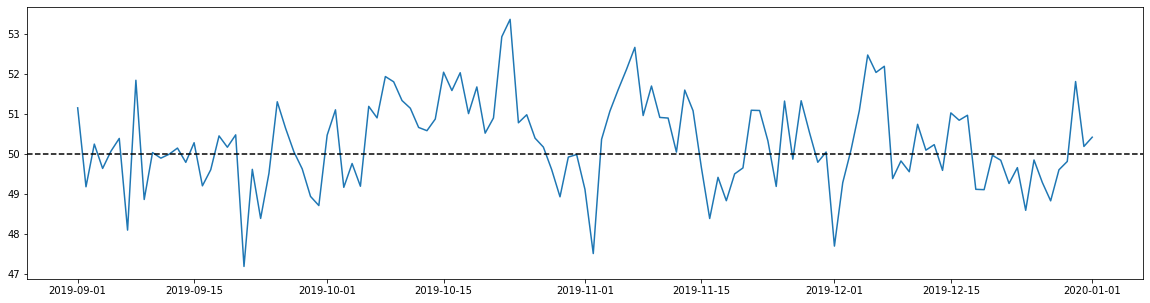

In [9]:
plt.figure(figsize=(20,5))
plt.plot(series)
plt.axhline(mu,linestyle = '--',color = 'black')

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


<BarContainer object of 10 artists>

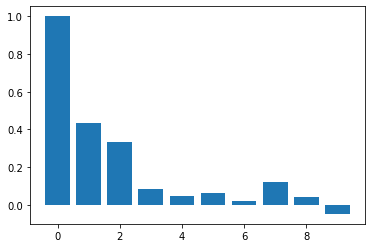

In [11]:
## let's see ACF
acf_val = acf(series)
num_lag = 10
plt.bar(range(num_lag),acf_val[:num_lag])

<BarContainer object of 25 artists>

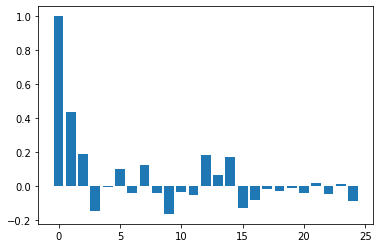

In [12]:
#let's see PACF
pacf_val = pacf(series)
num_lags = 25
plt.bar(range(num_lags),pacf_val[:num_lags])

In [13]:
train_end = datetime(2019,12,30)
test_end = datetime(2020,1,1)

train_data = series[:train_end]
test_data = series[train_end + timedelta(days=1):test_end]

In [14]:
#create the model
model = ARIMA(train_data, order=(0,0,2))

In [15]:
#fit the model
model_fit = model.fit()

In [16]:
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  121
Model:                     ARMA(0, 2)   Log Likelihood                -169.780
Method:                       css-mle   S.D. of innovations              0.983
Date:                Tue, 26 May 2020   AIC                            347.560
Time:                        05:58:21   BIC                            358.743
Sample:                    09-01-2019   HQIC                           352.102
                         - 12-30-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.3001      0.155    323.766      0.000      49.996      50.605
ma.L1.y        0.3845      0.088      4.381      0.000       0.213       0.557
ma.L2.y        0.3631      0.080      4.531      0.0


## Predicted Model:
$\hat{y}_t = 50.3 + 0.38\varepsilon_{t-1} + 0.36\varepsilon_{t-2}$

In [18]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [19]:
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)

In [20]:
residuals = test_data - predictions

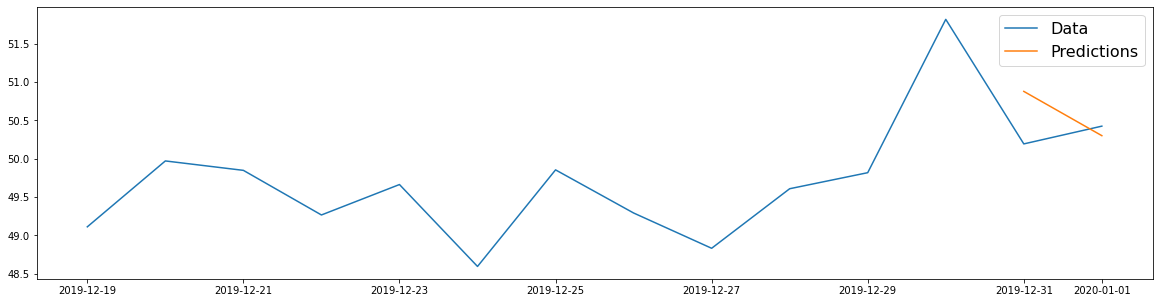

In [29]:
plt.figure(figsize=(20,5))

plt.plot(series[-14:])
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

In [22]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.008


In [23]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 0.49178750388345444


### very good model with 2 lags